# NLP - Assignment 2
## HW Group 7

You work for a university that wants to make searching for research articles easier.  The plan is to train a machine learning model that tags articles with one of several predefined categories, that will be used as metadata by the university's search engine. Graciously, the university has provided you with the necessary data.

The university wants the process of tagging any new research articles to be an overnight process, as the new articles do not need to be made immediately available to users. When searching, users have a preference for not being shown articles that are irrelevant to their search.

> **Notes:**
> - Code for reading the data is listed below.
> - The data comes with "title" and "abstract" fields. You may use either (or both) for your modeling.
> - The "subject" field is your target.
> - Preprocess your text accordingly (if you plan to try a BOW model, what kind of preprocessing makes sense?)
> - Try at least 3 models (non-deep learning only).
> - Your submission must include some kind of output that evaluates the chosen models so the grader can understand your model of choice.
> - Submit your assignment as a .ipynb and a .html or .pdf file

> **Answer the following questions:**
> - What kind of models did you try and why?
> - How did you evaluate the model and which metric do you think is most important? Hint: Read the second paragraph introducing the assignment.
> - How did you investigate misclassifications?
> - Were the misclassifications understandable (genuinely difficult examples) or were they blatant errors? Provide a few examples.

In [2]:
import os
import sys
from itertools import chain

import spacy
import multiprocessing
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf
from collections import Counter
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC

pd.options.display.max_colwidth = None

In [3]:
RANDOM_STATE = 42
SPACY_MODEL = "en_core_web_md"

## Dataset Overview

In [4]:
url = "https://storage.googleapis.com/adsp-nlp-open/data/elsevier-oa-cc-by/abstracts.json"
data = pd.read_json(url, orient="records")

In [5]:
data.head()

,doc_id,title,abstract,subject
0,S0960076016300644,Sterols and oxysterols in plasma from Smith-Lemli-Opitz syndrome patients,"Smith-Lemli-Opitz syndrome (SLOS) is a severe autosomal recessive disorder resulting from defects in the cholesterol synthesising enzyme 7-dehydrocholesterol reductase (Δ7-sterol reductase, DHCR7, EC 1.3.1.21) leading to a build-up of the cholesterol precursor 7-dehydrocholesterol (7-DHC) in tissues and blood plasma. Although the underling enzyme deficiency associated with SLOS is clear there are likely to be multiple mechanisms responsible for SLOS pathology. In an effort to learn more of the aetiology of SLOS we have analysed plasma from SLOS patients to search for metabolites derived from 7-DHC which may be responsible for some of the pathology. We have identified a novel hydroxy-8-dehydrocholesterol, which is either 24- or 25-hydroxy-8-dehydrocholesterol and also the known metabolites 26-hydroxy-8-dehydrocholesterol, 4-hydroxy-7-dehydrocholesterol, 3β,5α-dihydroxycholest-7-en-6-one and 7α,8α-epoxycholesterol. None of these metabolites are detected in control plasma at quantifiable levels (0.5 ng/mL).",phys_sci
1,S1471492219301369,The Uncertainty Surrounding the Burden of Post-acute Consequences of Dengue Infection,"Post-acute consequences currently form a significant component of the dengue disability-adjusted life year (DALY) burden estimates. However, there is considerable uncertainty regarding the incidence, duration, and severity of these symptoms. Further research is needed to more accurately estimate the health and economic burden of these dengue manifestations.",healh_sci
2,S2405580815000801,Low-mass molecular dynamics simulation for configurational sampling enhancement: More evidence and theoretical explanation,"It has been reported recently that classical, isothermal-isobaric molecular dynamics (NTP MD) simulations at a time step of 1.00fs of the standard-mass time (δt=1.00fssmt) and a temperature of ≤340K using uniformly reduced atomic masses by tenfold offers better configurational sampling than standard-mass NTP MD simulations at the same time step. However, it has long been reported that atomic masses can also be increased to improve configurational sampling because higher atomic masses permit the use of a longer time step. It is worth investigating whether standard-mass NTP MD simulations at δt=2.00 or 3.16fssmt can offer better or comparable configurational sampling than low-mass NTP MD simulations at δt=1.00fssmt. This article reports folding simulations of two β-hairpins showing that the configurational sampling efficiency of NTP MD simulations using atomic masses uniformly reduced by tenfold at δt=1.00fssmt is statistically equivalent to and better than those using standard masses at δt=3.16 and 2.00fssmt, respectively. The results confirm that, relative to those using standard masses at routine δt=2.00fssmt, the low-mass NTP MD simulations at δt=1.00fssmt are a simple and generic technique to enhance configurational sampling at temperatures of ≤340K.",phys_sci
3,S0142961216305853,Modulation of the molecular arrangement in artificial and biological membranes by phospholipid-shelled microbubbles,"The transfer of material from phospholipid-coated microbubbles to cell membranes has been hypothesized to play a role in ultrasound-mediated drug delivery. In this study, we employed quantitative fluorescence microscopy techniques to investigate this phenomenon in both artificial and biological membrane bilayers in an acoustofluidic system. The results of the present study provide strong evidence for the transfer of material from microbubble coatings into cell membranes. Our results indicate that transfer of phospholipids alters the organization of molecules in cell membranes, specifically the lipid ordering or packing, which is known to be a key determinant of membrane mechanical properties, protein dynamics, and permeability. We further show that polyethylene-glycol, used in many clinical

## Data Preprocessing

In [6]:
def clean_text(corpus, spacy_pipeline, n_proc=2, batch_size=1000):
    """
    Cleans a sequence of text by applying some simple processing techniques.

    Args:
        corpus (Iterable): a sequence of text to be processed
        spacy_pipeline: the Spacy pipeline object for processing text
        n_proc (int): the number of processors to use for parallel processing
        batch_size (int): the number of texts to process in a single batch

    Returns:
        clean_sequence (list): a cleaned version of the original text
    """
    # container to store cleaned documents
    corpus_clean = []

    for doc in spacy_pipeline.pipe(
        corpus,
        disable=["ner"],
        n_process=n_proc,
        batch_size=batch_size
    ):

        # container for cleaned document tokens
        doc_tokens = [
            token.lemma_.lower().strip()
            for token in doc
            if not any([token.is_stop, token.is_punct, token.is_space])
        ]

        # recombining tokens into a string
        clean_doc = " ".join(doc_tokens)
        
        corpus_clean.append(clean_doc)

    return corpus_clean


def ratio_nonzero(arr):
    """Determines the ration of nonzero elements in an array"""
    return np.count_nonzero(arr) / arr.size

In [7]:
CATEGORIES = data['subject'].unique().tolist()
CATEGORIES

['phys_sci', 'healh_sci', 'engi_tech', 'life_sci', 'soc_sci']

In [8]:
data["info"] = data["title"] + " " + data["abstract"]

# simple clearning step
data["text_clean_light"] = (
    data["info"]
    .str.replace(r"(\s)+", " ", regex=True, )
    .str.replace(r"([^a-zA-Z0-9])\1+", r"\1", regex=True) # replacing repeat occurances of nonalphanumeric with just one occurance. the "\1" is called a back reference in regex
)

# load spacy model
nlp = spacy.load(SPACY_MODEL)

# apply cleaning to data
data['text_clean_heavy'] = clean_text(
    corpus=data["text_clean_light"].tolist(),
    spacy_pipeline=nlp,
    n_proc=multiprocessing.cpu_count() - 2
)

# adding encoding column
# label encoder will be used later to make classification report look more clear
label_encoder = LabelEncoder()
data["target"] = label_encoder.fit_transform(data["subject"])

# printing out the subject counts
print(
    data["subject"].value_counts(),
    data["subject"].value_counts(normalize=True),
    sep="\n\n"
)

data.sample(3)

subject
phys_sci     13048
engi_tech     9211
healh_sci     7633
life_sci      5651
soc_sci       3143
Name: count, dtype: int64

subject
phys_sci     0.337280
engi_tech    0.238096
healh_sci    0.197307
life_sci     0.146074
soc_sci      0.081244
Name: proportion, dtype: float64


,doc_id,title,abstract,subject,info,text_clean_light,text_clean_heavy,target
12275,S0306261916310534,Climate change mitigation in Chinese megacities: A measures-based analysis of opportunities in the residential sector,"China's commitment to the UNFCCC to peak its emissions by 2030, or sooner, signaled a long anticipated shift in China's model of development with far reaching consequences. Cities in China, and particularly the residential sector in cities, will be charged with making significant reductions in emissions growth even as rates of urbanization continue to climb. Focusing on Beijing and Shanghai, this paper carries out a measures-based economic analysis of low carbon investment opportunities in the residential sector. Results find significant opportunity: between 2015 and 2030, BAU levels of CO2 emissions could be reduced by 10.2% in Beijing and 6.8% in Shanghai with the adoption of economically attractive low carbon measures. While these headline results underline the case for low carbon investment in the residential sectors of these megacities in China, a closer analysis provides insights for understanding the economics of decarbonisation in cities more generally.",engi_tech,"Climate change mitigation in Chinese megacities: A measures-based analysis of opportunities in the residential sector China's commitment to the UNFCCC to peak its emissions by 2030, or sooner, signaled a long anticipated shift in China's model of development with far reaching consequences. Cities in China, and particularly the residential sector in cities, will be charged with making significant reductions in emissions growth even as rates of urbanization continue to climb. Focusing on Beijing and Shanghai, this paper carries out a measures-based economic analysis of low carbon investment opportunities in the residential sector. Results find significant opportunity: between 2015 and 2030, BAU levels of CO2 emissions could be reduced by 10.2% in Beijing and 6.8% in Shanghai with the adoption of economically attractive low carbon measures. While these headline results underline the case for low carbon investment in the residential sectors of these megacities in China, a closer analysis provides insights for understanding the economics of decarbonisation in cities more generally.","Climate change mitigation in Chinese megacities: A measures-based analysis of opportunities in the residential sector China's commitment to the UNFCCC to peak its emissions by 2030, or sooner, signaled a long anticipated shift in China's model of development with far reaching consequences. Cities in China, and particularly the residential sector in cities, will be charged with making significant reductions in emissions growth even as rates of urbanization continue to climb. Focusing on Beijing and Shanghai, this paper carries out a measures-based economic analysis of low carbon investment opportunities in the residential sector. Results find significant opportunity: between 2015 and 2030, BAU levels of CO2 emissions could be reduced by 10.2% in Beijing and 6.8% in Shanghai with the adoption of economically attractive low carbon measures. While these headline results underline the case for low carbon investment in the residential sectors of these megacities in China, a closer analysis provides insights for understanding the economics of decarbonisation in cities more generally.",climate change mitigation chinese megacitie measure base analysis opportunity residential sector china commitment unfccc peak emission 2030 soon signal long anticipated shift china model development far reach consequence city china particularly residential sector city charge make significant reduction emission growth rate urbanization continue climb focus beijing shanghai paper carry measure base economic analysis low carbon investment opportunity residential sector result find significant opportunity 2015 2030 bau level co2 emission reduce 10.2 beijing 6.8 shanghai adoption economically attrac

## EDA

count    38686.000000
mean       225.416611
std         80.408535
min         23.000000
25%        168.000000
50%        218.000000
75%        268.000000
max       1078.000000
Name: text_clean_light, dtype: float64


<Axes: >

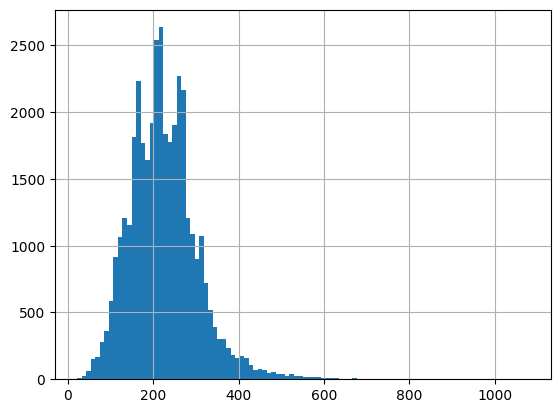

In [9]:
# checking to see the length of the documents
length_series = data["text_clean_light"].str.split().str.len()

print(length_series.describe())
length_series.hist(bins=100)

count    38686.000000
mean         0.630669
std          0.066428
min          0.314286
25%          0.586081
50%          0.628099
75%          0.672606
max          0.965517
Name: ttr, dtype: float64


<Axes: >

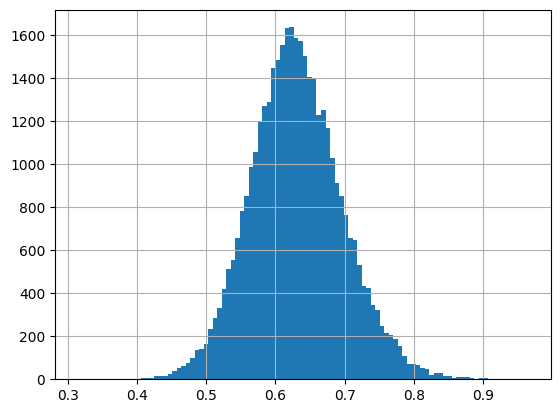

In [10]:
# type token ratio measure the diveristy in text (can help identify excessive repition)
def calc_ttr(text: str) -> float:
    words = text.split()
    unique_words = len(set(words))
    total_words = len(words)
    return unique_words / total_words if total_words > 0 else 0


# checking to see the length of the documents
data["ttr"] = data["text_clean_light"].apply(calc_ttr)

print(data["ttr"].describe())
data["ttr"].hist(bins=100)

In [11]:
data.query("ttr > 0.95")

,doc_id,title,abstract,subject,info,text_clean_light,text_clean_heavy,target,ttr
11374,S0960982218312843,Two Interlinked Bistable Switches Govern Mitotic Control in Mammalian Cells,"Rata et al. combine quantitative assays with mathematical modeling to show that hysteresis of the mitotic switch emerges from mutual effects of Cdk1 and its counteracting phosphatase, PP2A:B55, on each other's auto-activation loops. Their work also reveals an intermediate but hidden steady state between interphase and M phase.",life_sci,"Two Interlinked Bistable Switches Govern Mitotic Control in Mammalian Cells Rata et al. combine quantitative assays with mathematical modeling to show that hysteresis of the mitotic switch emerges from mutual effects of Cdk1 and its counteracting phosphatase, PP2A:B55, on each other's auto-activation loops. Their work also reveals an intermediate but hidden steady state between interphase and M phase.","Two Interlinked Bistable Switches Govern Mitotic Control in Mammalian Cells Rata et al. combine quantitative assays with mathematical modeling to show that hysteresis of the mitotic switch emerges from mutual effects of Cdk1 and its counteracting phosphatase, PP2A:B55, on each other's auto-activation loops. Their work also reveals an intermediate but hidden steady state between interphase and M phase.",interlinked bistable switches govern mitotic control mammalian cells rata et al combine quantitative assay mathematical modeling hysteresis mitotic switch emerge mutual effect cdk1 counteract phosphatase pp2a b55 auto activation loop work reveal intermediate hide steady state interphase m phase,2,0.965517


In [12]:
# removing empty strings
print("before:", data.shape[0])
data_df = data.loc[data["text_clean_light"].str.strip() != ""]
print("after:", data.shape[0])

before: 38686
after: 38686


## Modeling

For this assignment, we mainly explore four models in two big categories (TF-IDF Model and BOW Model):
> - TF-IDF Model
> - BOW Model

> - Logistic Regression
> - Multinomial Naive Bayes
> - Random Forest
> - Support Vector Machine (Linear SVM)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data["text_clean_heavy"], data["target"], test_size=0.2, random_state=RANDOM_STATE, stratify=data["target"]
)

### TF-IDF Model

In [14]:
# TF-IDF
tfidf = TfidfVectorizer(stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression — TF-IDF
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
print("Logistic Regression (TF-IDF)\n")
print(classification_report(y_test, lr_tfidf.predict(X_test_tfidf), target_names=label_encoder.classes_))

# Naive Bayes — TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
print("Naive Bayes (TF-IDF)\n")
print(classification_report(y_test, nb_tfidf.predict(X_test_tfidf), target_names=label_encoder.classes_))

# Random Forest — TF-IDF
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_tfidf.fit(X_train_tfidf, y_train)
print("Random Forest (TF-IDF)\n")
print(classification_report(y_test, rf_tfidf.predict(X_test_tfidf), target_names=label_encoder.classes_))

# Support Vector Machine (LinearSVC) — TF-IDF
svm_tfidf = LinearSVC(random_state=RANDOM_STATE)
svm_tfidf.fit(X_train_tfidf, y_train)
print("Support Vector Machine (TF-IDF)\n")
print(classification_report(y_test, svm_tfidf.predict(X_test_tfidf), target_names=label_encoder.classes_))

Logistic Regression (TF-IDF)

              precision    recall  f1-score   support

   engi_tech       0.78      0.78      0.78      1842
   healh_sci       0.79      0.79      0.79      1527
    life_sci       0.66      0.55      0.60      1130
    phys_sci       0.68      0.75      0.71      2610
     soc_sci       0.74      0.66      0.70       629

    accuracy                           0.73      7738
   macro avg       0.73      0.71      0.72      7738
weighted avg       0.73      0.73      0.73      7738

Naive Bayes (TF-IDF)

              precision    recall  f1-score   support

   engi_tech       0.74      0.77      0.76      1842
   healh_sci       0.73      0.70      0.71      1527
    life_sci       0.74      0.11      0.19      1130
    phys_sci       0.53      0.84      0.65      2610
     soc_sci       0.98      0.07      0.12       629

    accuracy                           0.62      7738
   macro avg       0.74      0.50      0.49      7738
weighted avg       0.69  

### BoW Model

In [ ]:
# BoW
bow = CountVectorizer(stop_words='english')
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

# Logistic Regression — BoW
lr_bow = LogisticRegression(max_iter=1000)
lr_bow.fit(X_train_bow, y_train)
print("Logistic Regression (BoW)\n")
print(classification_report(y_test, lr_bow.predict(X_test_bow), target_names=label_encoder.classes_))

# Naive Bayes — BoW
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
print("Naive Bayes (BoW)\n")
print(classification_report(y_test, nb_bow.predict(X_test_bow), target_names=label_encoder.classes_))

# Random Forest — BoW
rf_bow = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_bow.fit(X_train_bow, y_train)
print("Random Forest (BoW)\n")
print(classification_report(y_test, rf_bow.predict(X_test_bow), target_names=label_encoder.classes_))

# Support Vector Machine (LinearSVC) — BoW
svm_bow = LinearSVC(random_state=RANDOM_STATE)
svm_bow.fit(X_train_bow, y_train)
print("Support Vector Machine (BoW)\n")
print(classification_report(y_test, svm_bow.predict(X_test_bow), target_names=label_encoder.classes_))

Logistic Regression (BoW)

              precision    recall  f1-score   support

   engi_tech       0.73      0.74      0.74      1842
   healh_sci       0.77      0.73      0.75      1527
    life_sci       0.58      0.55      0.56      1130
    phys_sci       0.66      0.70      0.68      2610
     soc_sci       0.68      0.65      0.67       629

    accuracy                           0.69      7738
   macro avg       0.69      0.67      0.68      7738
weighted avg       0.69      0.69      0.69      7738

Naive Bayes (BoW)

              precision    recall  f1-score   support

   engi_tech       0.70      0.83      0.76      1842
   healh_sci       0.76      0.78      0.77      1527
    life_sci       0.63      0.61      0.62      1130
    phys_sci       0.75      0.57      0.65      2610
     soc_sci       0.55      0.79      0.65       629

    accuracy                           0.70      7738
   macro avg       0.68      0.72      0.69      7738
weighted avg       0.71      0.

### Model Evaluations

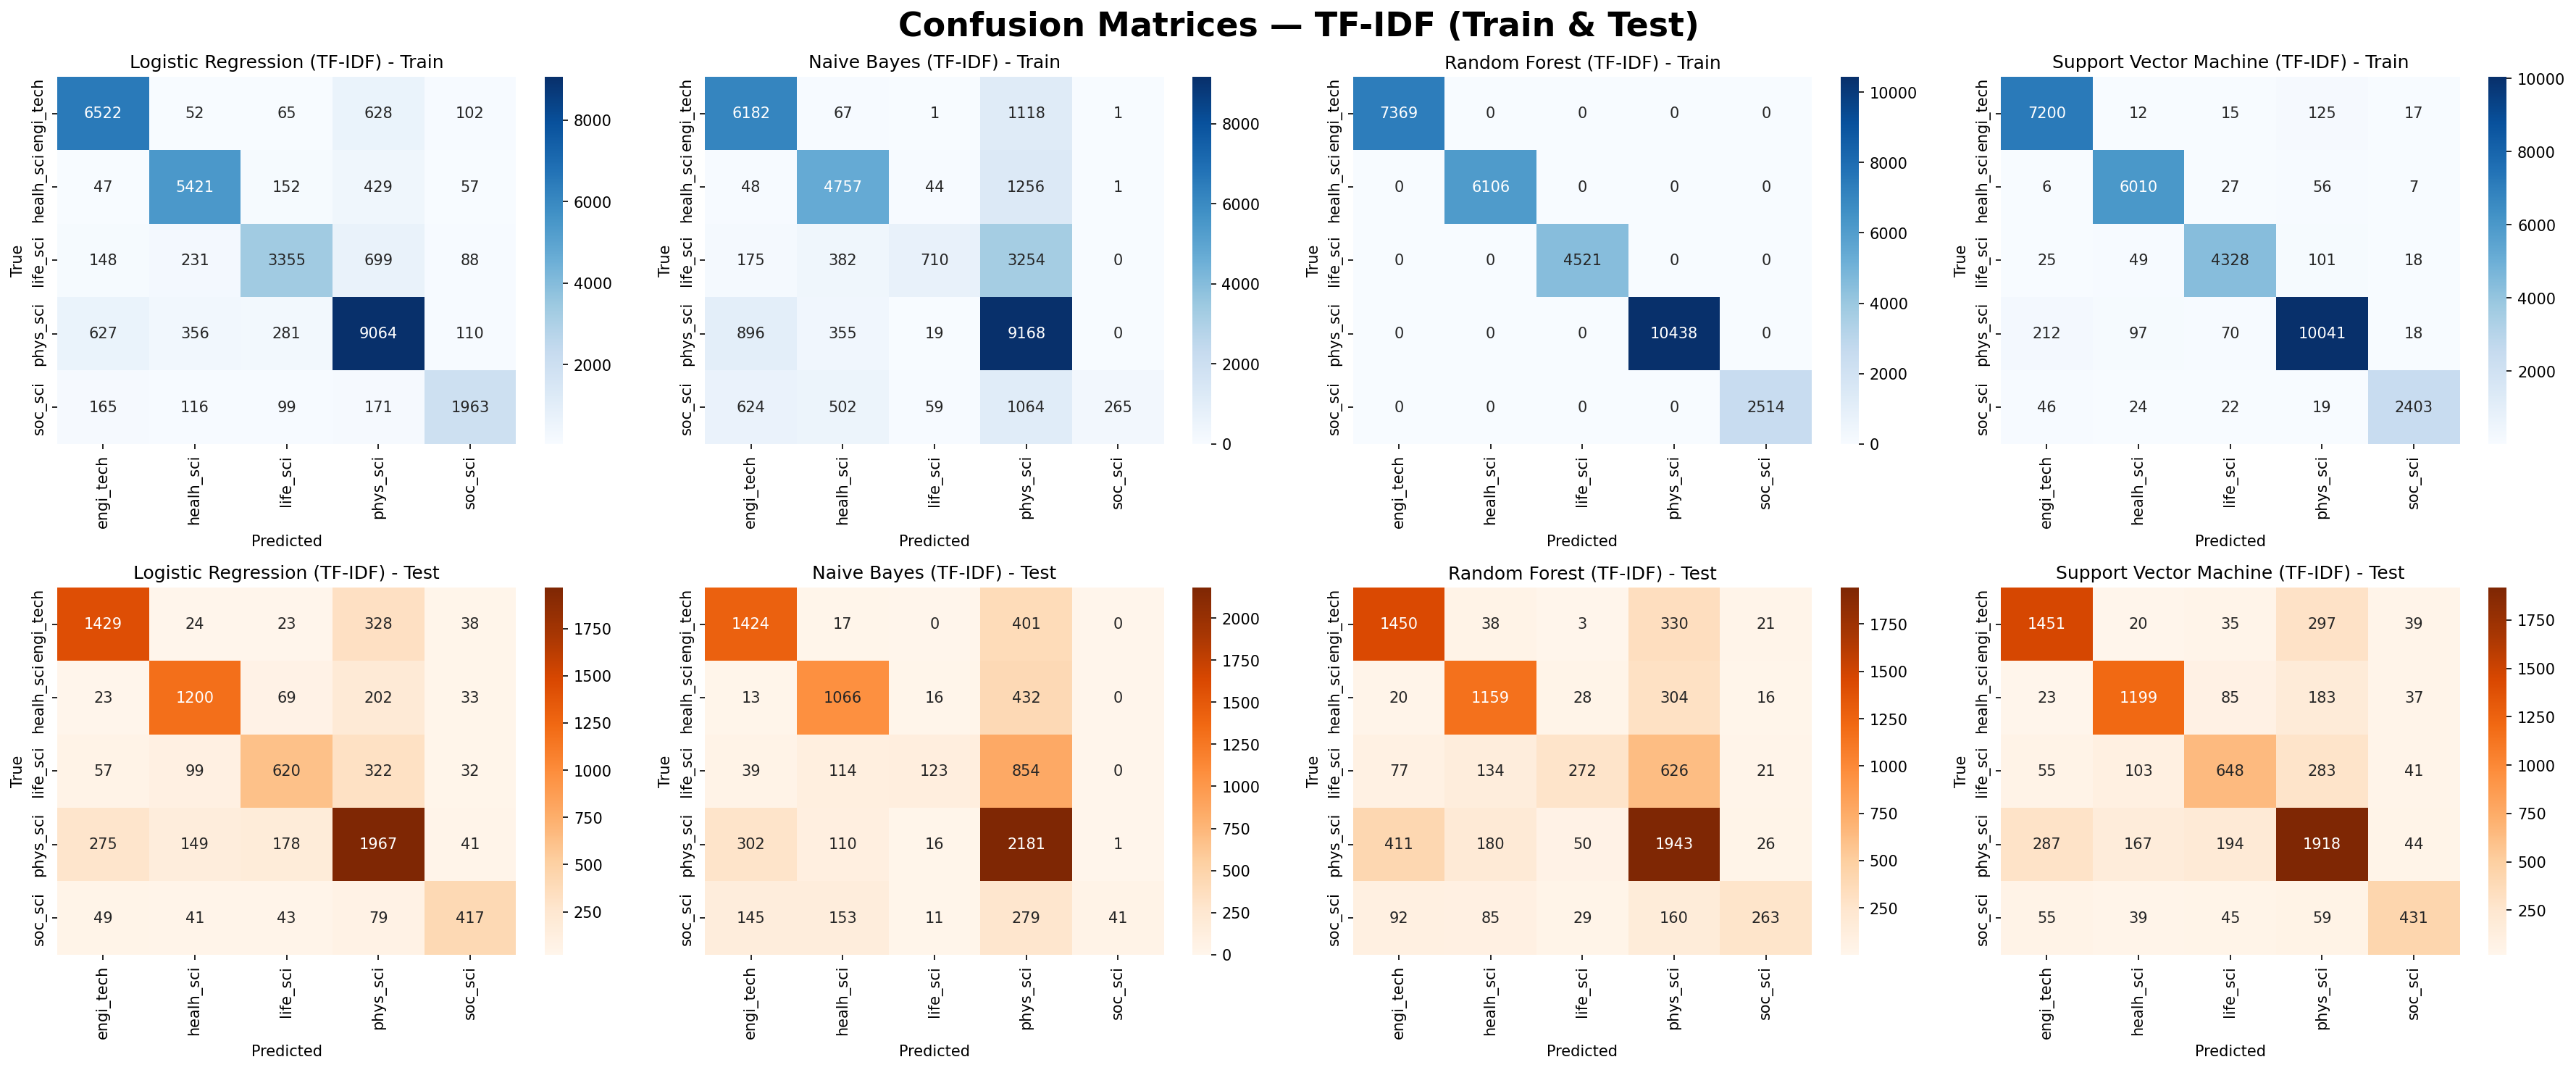

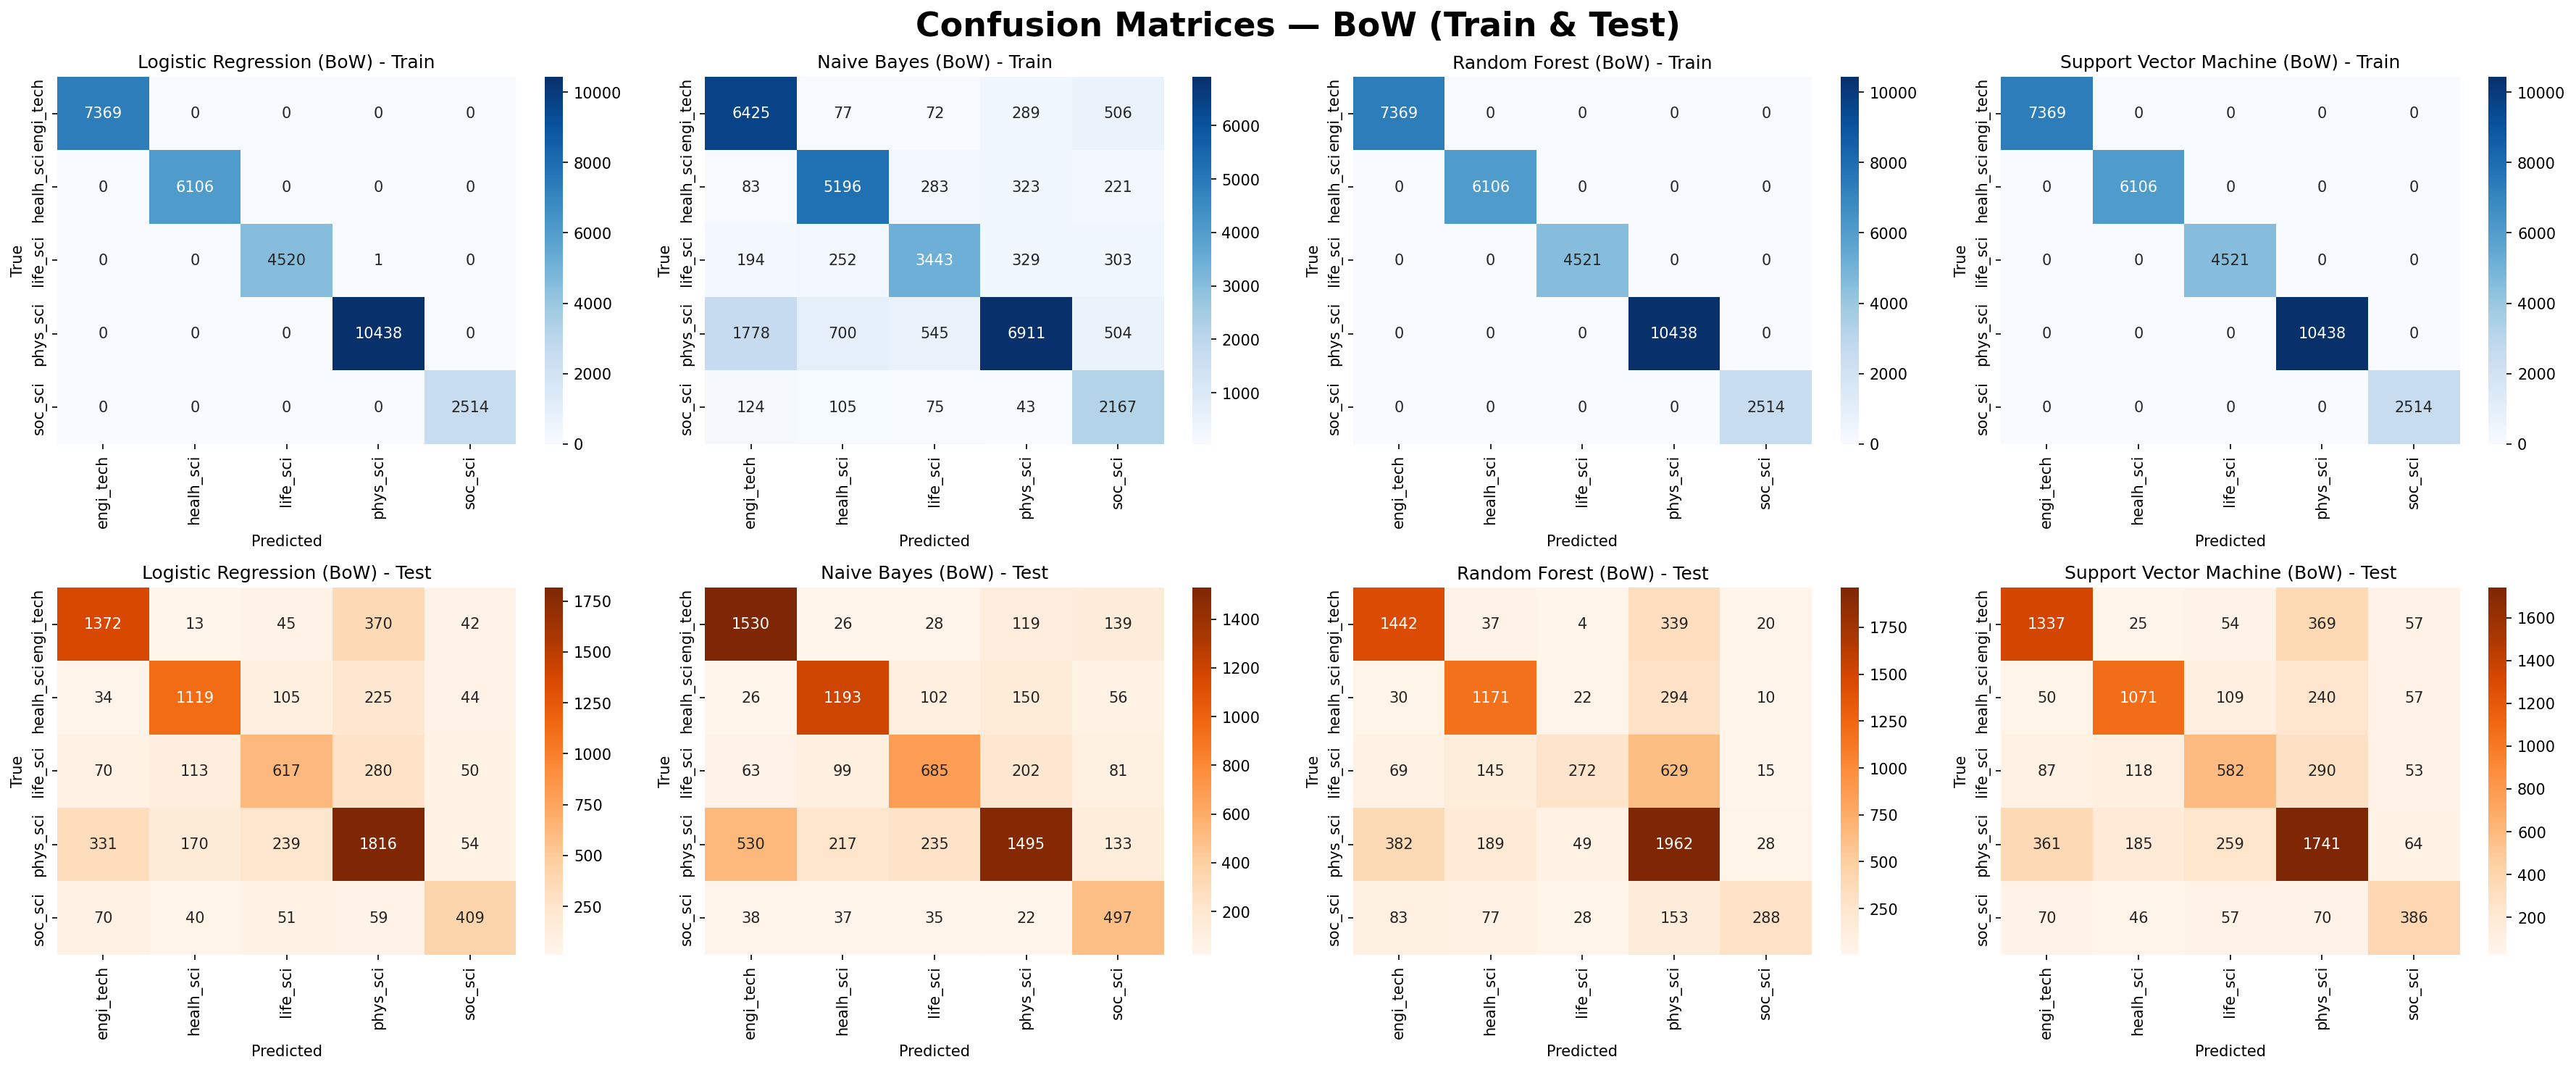

In [16]:
# Make predictions
# TF-IDF
y_train_pred_lr_tfidf = lr_tfidf.predict(X_train_tfidf)
y_test_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)
y_train_pred_nb_tfidf = nb_tfidf.predict(X_train_tfidf)
y_test_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)
y_train_pred_rf_tfidf = rf_tfidf.predict(X_train_tfidf)
y_test_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)
y_train_pred_svm_tfidf = svm_tfidf.predict(X_train_tfidf)
y_test_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

# BoW
y_train_pred_lr_bow = lr_bow.predict(X_train_bow)
y_test_pred_lr_bow = lr_bow.predict(X_test_bow)
y_train_pred_nb_bow = nb_bow.predict(X_train_bow)
y_test_pred_nb_bow = nb_bow.predict(X_test_bow)
y_train_pred_rf_bow = rf_bow.predict(X_train_bow)
y_test_pred_rf_bow = rf_bow.predict(X_test_bow)
y_train_pred_svm_bow = svm_bow.predict(X_train_bow)
y_test_pred_svm_bow = svm_bow.predict(X_test_bow)

# Organize predictions
models_tfidf = {
    "Logistic Regression (TF-IDF)": (y_train_pred_lr_tfidf, y_test_pred_lr_tfidf),
    "Naive Bayes (TF-IDF)": (y_train_pred_nb_tfidf, y_test_pred_nb_tfidf),
    "Random Forest (TF-IDF)": (y_train_pred_rf_tfidf, y_test_pred_rf_tfidf),
    "Support Vector Machine (TF-IDF)": (y_train_pred_svm_tfidf, y_test_pred_svm_tfidf)
}

models_bow = {
    "Logistic Regression (BoW)": (y_train_pred_lr_bow, y_test_pred_lr_bow),
    "Naive Bayes (BoW)": (y_train_pred_nb_bow, y_test_pred_nb_bow),
    "Random Forest (BoW)": (y_train_pred_rf_bow, y_test_pred_rf_bow),
    "Support Vector Machine (BoW)": (y_train_pred_svm_bow, y_test_pred_svm_bow)

}

# Plotting function
def plot_train_test_confusions(models_dict, y_train, y_test, label_encoder, title):
    n_models = len(models_dict)
    fig, axes = plt.subplots(nrows=2, ncols=n_models, figsize=(6 * n_models, 10), dpi=150)
    class_labels = label_encoder.classes_

    for col_idx, (model_name, (y_train_pred, y_test_pred)) in enumerate(models_dict.items()):
        # Training
        cm_train = confusion_matrix(y_train, y_train_pred)
        sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels, ax=axes[0][col_idx])
        axes[0][col_idx].set_title(f"{model_name} - Train")
        axes[0][col_idx].set_xlabel("Predicted")
        axes[0][col_idx].set_ylabel("True")

        # Testing
        cm_test = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm_test, annot=True, fmt="d", cmap="Oranges",
                    xticklabels=class_labels, yticklabels=class_labels, ax=axes[1][col_idx])
        axes[1][col_idx].set_title(f"{model_name} - Test")
        axes[1][col_idx].set_xlabel("Predicted")
        axes[1][col_idx].set_ylabel("True")

    plt.suptitle(title, fontsize=22, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_train_test_confusions(models_tfidf, y_train, y_test, label_encoder, "Confusion Matrices — TF-IDF (Train & Test)")
plot_train_test_confusions(models_bow, y_train, y_test, label_encoder, "Confusion Matrices — BoW (Train & Test)")

## Analysis: Answer the following questions

### What kind of models did you try and why?

> This is a supervised classification project, where the goal is to predict the correct subject label for a research article based on its title and abstract. I experimented with four different models: <u>Logistic Regression, Multinomial Naive Bayes, Random Forest, and Support Vector Machine</u>, which represent both <u>discriminative and generative approaches</u>.
> - **Logistic Regression** is a linear discriminative model commonly used in text classification. It works well with high-dimensional, sparse data such as TF-IDF or Bag-of-Words features. It is efficient, robust, and often serves as a strong baseline for supervised learning tasks.
> - **Multinomial Naive Bayes** is a generative model based on probabilistic assumptions of word distributions within classes. It is fast to train, works well with raw frequency-based features like BoW, and is known to perform well in many natural language processing tasks.
> - **Random Forest** is a non-linear ensemble method based on decision trees. We included it to evaluate whether a model capable of capturing feature interactions could improve performance, even though it's less common for raw text data.
> - **Support Vector Machine (SVM)** is a linear discriminative model effective for high-dimensional text data. We included it for its strong generalization and margin-maximizing properties, which help reduce irrelevant article classifications—a key priority for this task.

> To understand how vectorization influences model performance, we applied both TF-IDF and Bag-of-Words representations to all four models. This allowed for a systematic comparison of how each model responds to different types of textual feature engineering, and provided insights into which combinations yielded the most accurate and stable predictions.

### How did you evaluate the model and which metric do you think is most important? 
Hint: Read the second paragraph introducing the assignment.

> Since the task is to avoid showing users irrelevant articles, I evaluated the models with a primary focus on precision — the proportion of correctly predicted articles within each predicted category.
> In this context, misclassifications can be interpreted as follows:
> - A **false negative (FN)** means an article that the user would have been interested in was not shown. While not ideal, this is acceptable because the user simply doesn't see the article.
> - A **false positive (FP)** means an irrelevant article is shown to the user, which directly goes against the goal of improving the search experience.
> Therefore, the model should aim to maximize true positives (TP) — showing users relevant articles — while minimizing false positives (FP). This makes **precision** the most important evaluation metric for this task.

> To evaluate model performance, I used:
> - A stratified 80/20 train-test split
> - Standard classification metrics: precision, recall, F1-score, and accuracy
> - Confusion matrices to visualize misclassifications for each subject class

> Findings:
> - When using Bag-of-Words (BoW), precision and accuracy were fairly consistent across all four models, with precision ranging from 68% to 71% and accuracy ranging from 66% to 70%.
> - When using TF-IDF, accuracy varied more significantly across models (62% to 73%), but precision remained relatively stable, ranging from 67% to 74%.

> These results reinforce the importance of focusing on precision rather than just overall accuracy, as it better aligns with the project's objective of minimizing irrelevant results in the search engine.

### How did you investigate misclassifications?

> To investigate misclassifications, I created a comparison table that included <u>each article’s title, abstract, predicted label, and true label</u>. I did this using the following code, which allowed me to closely read misclassified examples and determine whether the errors were understandable or potentially correctable:

In [17]:
# Predict on the test set
y_pred = lr_tfidf.predict(X_test_tfidf)  # or change to nb_bow.predict(X_test_bow), etc.

# Get back the original X_test (text), and align it with the index
X_test_raw = X_test.reset_index(drop=True)
y_test_raw = y_test.reset_index(drop=True)

# Create a DataFrame to compare predictions
misclassified_df = pd.DataFrame({
    "title": data.loc[X_test_raw.index, "title"].values,
    "abstract": data.loc[X_test_raw.index, "abstract"].values,
    "text_clean": X_test_raw,
    "true_label": label_encoder.inverse_transform(y_test_raw),
    "predicted_label": label_encoder.inverse_transform(y_pred)
})

# Filter to only show misclassified rows
misclassified_df = misclassified_df[misclassified_df["true_label"] != misclassified_df["predicted_label"]]

# Show top 5 examples
misclassified_df.head(5)


,title,abstract,text_clean,true_label,predicted_label
10,Investigating char agglomeration in blast furnace coal injection,"Blast furnace iron manufacturers aim to reduce expensive coke usage through the injection of coal. This paper investigates contrasting agglomeration behaviour with a view towards optimising blast furnace operations and limiting furnace permeability issues. A drop tube furnace (DTF) was used to investigate the performance of two coal particle size specifications that were representative of injection coal sizes: pulverised (100% < 300 μm, 50% < 75 μm), and granulated (100% < 1 mm, 50% < 250 μm). A range of coals was subjected to DTF testing with issues arising from the injection of caking coals. Results show these coals exhibit signs of agglomeration, a potentially problematic effect concerning blast furnace permeability. Considering gasification reactivity upon leaving the blast furnace raceway, it was found that the agglomerated coal chars do not suffer from poor reactivity and are more reactive than the non-agglomerated chars. Pre-treatment through oxidation was found to be an effective means of eliminating agglomeration in the DTF as a result of the reduction in caking properties.","prevotella copri complex comprises distinct clades underrepresente westernized populations prevotella copri common human gut microbe positively negatively associate host health cross continent meta analysis exploit > 6,500 metagenome obtain > 1,000 genome explore genetic population structure p. copri p. copri encompass distinct clade > 10 inter clade genetic divergence propose constitute p. copri complex clade confirm isolate sequencing clade nearly ubiquitous co present non westernized population genomic analysis show substantial functional diversity complex notable difference carbohydrate metabolism suggest multi generational dietary modification drive reduce prevalence westernized population analysis ancient metagenome highlight pattern p. copri presence consistent modern non westernized population clade delineation time pre date human migratory wave africa finding reveal p. copri exhibit high diversity underrepresente western lifestyle population",healh_sci,phys_sci
16,A systematic review of adverse events following immunization during pregnancy and the newborn period,"In 2013, the WHO Strategic Advisory Group of Experts on Immunization (SAGE) requested WHO to develop a process and a plan to move the maternal immunization agenda forward in support of an increased alignment of data safety evidence, public health needs, and regulatory processes. A key challenge identified was the continued need for harmonization of maternal adverse event following immunization (AEFI) research and surveillance efforts within developing and developed country contexts. We conducted a systematic review as a preliminary step in the development of standardized AEFI definitions for use in maternal and neonatal clinical trials, post-licensure surveillance, and other vaccine studies. We documented the current extent and nature of variability in AEFI definitions and adverse event reporting among 74 maternal immunization studies, which reported a total of 240 different types of adverse events. Forty-nine studies provided explicit AEFI case definitions describing 35 separate types of AEFIs. We identified variability in how AEFIs were determined to be present, in how AEFI definitions were applied, and in the ways that AEFIs were reported. Definitions for key maternal/neonatal AEFIs differed on four discrete attributes: overall level of detail, physiological and temporal boundaries and cut-offs, severity strata, and standards used. Our findings suggest that investigators may proactively address these inconsistencies through comprehensive and consistent reporting of AEFI definitions and outcomes in future publications. In addition, efforts to develop standardized AEFI definitions should generate definitions of sufficient detail and consistency of language

### Were the misclassifications understandable (genuinely difficult examples) or were they blatant errors? Provide a few examples.

> Most of the misclassifications were genuinely difficult and understandable, even from a human perspective — particularly for someone who is not a subject-matter expert in the research domains. Here are a few examples:

> - Title: "Investigating char agglomeration in blast furnace coal injection"
> - True label: health_sci | Predicted: phys_sci
> - At first glance, this article discusses topics like "coal," "furnace," and "iron" — which are strongly associated with physics or engineering. Without domain-specific knowledge, it's easy to see why the model misclassified it. Even I initially leaned toward physics before reconsidering its health-related implications.

> - Title: "A systematic review of adverse events following immunization during pregnancy and the newborn period"
> - True label: phys_sci | Predicted: engi_tech
> - This error is understandable, as the article mentions "definitions," "standardization," and "systems," which may resemble engineering-related language. The line between physical science and engineering can be very nuanced, especially in areas like medical devices or immunology.

> - Title: "Characterization of tropical hemispaces by (P, R)-decompositions"
> - True label: life_sci | Predicted: health_sci
> - This is a borderline case where the vocabulary is highly technical and abstract. The model likely associated terms like “life”, “health”, and “clinical” too broadly. Even as a reader, it’s difficult to confidently assign this to a category without deeper subject expertise.

> Overall, the errors were not random or careless, but rather reflected semantic overlaps between categories, technical vocabulary, and interdisciplinary content. These results show that even a well-performing model can struggle with edge cases — just as a human might.